In [33]:
%pip install mesa==2.1.1
%pip install matplotlib
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\aksel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\aksel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [34]:
import random
from mesa import Agent

class SimpsonAgentRandom(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.carrying_victim = False
        self.base_ap = 4

        self.victims_picked = 0
        self.victims_rescued = 0
        self.fires_extinguished = 0
        self.smokes_extinguished = 0
        self.doors_opened = 0
        self.action_points = 0  # AP gastados acumulados
        self.walls_broken = 0


    def get_available_actions(self, ap):
        actions = []
        x, y = self.pos

        # 1) Apagar fuego/humo (celda actual + vecinos ortogonales)
        positions_to_check = [self.pos] + list(
            self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        )

        for tx, ty in positions_to_check:
            hazard = self.model.hazard_grid[tx, ty]
            if hazard in (self.model.FIRE, self.model.SMOKE) and ap >= 1:
                actions.append({"type": "extinguish", "target": (tx, ty)})

        # Vecinos para moverse/puertas/paredes (SOLO ortogonal)
        neighbors = list(self.model.grid.get_neighborhood((x, y), moore=False, include_center=False))

        # 2) Abrir puertas (costo 1) y romper pared (costo 2)
        for nx, ny in neighbors:
            edge_type = self.model.edges.get(((x, y), (nx, ny)), "empty")

            if edge_type == "door_closed" and ap >= 1:
                actions.append({"type": "open_door", "from": (x, y), "to": (nx, ny)})

            # romper pared solo si hay AP suficiente
            if edge_type == "wall" and ap >= 2:
                actions.append({"type": "break_wall", "from": (x, y), "to": (nx, ny)})

        # 3) Moverse (no entrar a FIRE)
        for nx, ny in neighbors:
            if not self.model.can_move((x, y), (nx, ny)):
                continue

            if self.model.hazard_grid[nx, ny] == self.model.FIRE:
                continue

            move_cost = 2 if self.carrying_victim else 1
            if move_cost <= ap:
                actions.append({"type": "move", "to": (nx, ny), "cost": move_cost})

        return actions

    def execute_action(self, action, ap):
        t = action["type"]
        if t == "extinguish":
            return self.execute_extinguish(action, ap)
        if t == "open_door":
            return self.execute_open_door(action, ap)
        if t == "break_wall":
            return self.execute_break_wall(action, ap)
        if t == "move":
            return self.execute_move(action, ap)
        return ap

    def execute_extinguish(self, action, ap):
        tx, ty = action["target"]
        hazard = self.model.hazard_grid[tx, ty]

        if hazard not in (self.model.FIRE, self.model.SMOKE):
            return ap

        # SMOKE -> EMPTY (costo 1)
        if hazard == self.model.SMOKE:
            cost = 1
            if cost > ap:
                return ap
            self.model.hazard_grid[tx, ty] = self.model.EMPTY
            self.smokes_extinguished += 1
            self.action_points += cost
            self.model.sync_env_grid()
            return ap - cost

        # FIRE -> EMPTY (costo 2) o FIRE -> SMOKE (costo 1)
        if hazard == self.model.FIRE:
            if ap >= 2:
                cost = 2
                self.model.hazard_grid[tx, ty] = self.model.EMPTY
                self.fires_extinguished += 1
            else:
                cost = 1
                self.model.hazard_grid[tx, ty] = self.model.SMOKE
                self.smokes_extinguished += 1

            self.action_points += cost
            self.model.sync_env_grid()
            return ap - cost

        return ap

    def execute_open_door(self, action, ap):
        from_pos = action["from"]
        to_pos = action["to"]

        if ap < 1:
            return ap

        edge_type = self.model.edges.get((from_pos, to_pos), "empty")
        if edge_type != "door_closed":
            return ap

        self.model.set_edge(from_pos, to_pos, "door_open")
        self.doors_opened += 1
        self.action_points += 1
        self.model.sync_env_grid()
        return ap - 1

    def execute_break_wall(self, action, ap):
        from_pos = action["from"]
        to_pos = action["to"]

        # Romper pared cuesta 2 AP por intento (1 daño)
        if ap < 2:
            return ap

        edge_type = self.model.edges.get((from_pos, to_pos), "empty")
        if edge_type != "wall":
            return ap

        broke = self.model.damage_wall(from_pos, to_pos, dmg=1)  # baja HP y si llega a 0 -> 'empty'
        self.action_points += 2
        if broke:
            self.walls_broken += 1

        self.model.sync_env_grid()
        return ap - 2

    def execute_move(self, action, ap):
        cost = action["cost"]
        if cost > ap:
            return ap

        nx, ny = action["to"]
        if not self.model.can_move(self.pos, (nx, ny)):
            return ap

        if self.model.hazard_grid[nx, ny] == self.model.FIRE:
            return ap

        self.model.grid.move_agent(self, (nx, ny))
        self.action_points += cost
        self.model.sync_env_grid()
        return ap - cost

    def handle_victims(self):
        x, y = self.pos

        # Recoger víctima (aunque haya humo)
        if self.model.victim_grid[x, y] and not self.carrying_victim:
            self.carrying_victim = True
            self.model.victim_grid[x, y] = False
            self.victims_picked += 1
            self.model.sync_env_grid()

        # Dejar en ambulancia
        if (x, y) == self.model.ambulance_pos and self.carrying_victim:
            self.carrying_victim = False
            self.victims_rescued += 1

            self.model.victims_rescued_total += 1
            self.model.victims_update(1)
            self.model.sync_env_grid()

    def step(self):
        ap = self.base_ap
        self.handle_victims()

        while ap > 0:
            available_actions = self.get_available_actions(ap)
            if not available_actions:
                break

            action = random.choice(available_actions)
            old_ap = ap
            ap = self.execute_action(action, ap)

            # safety: si por alguna razón una acción no gastó AP, rompemos para no ciclar
            if ap == old_ap:
                break

            self.handle_victims()


In [35]:
import random
import numpy as np
from mesa import Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector


class SimpsonRandomModel(Model):
    # Visual/legacy codes (para tu colormap)
    EMPTY = 0
    FIRE = 1
    SMOKE = 2
    VICTIM = 3
    DOOR_CLOSED = 4
    DOOR_OPEN = 5
    AMBULANCE = 6
    FIREFIGHTER = 7
    VICTIM_SMOKE = 8  # víctima en celda con humo (solo viz)

    def __init__(
        self,
        width=10,
        height=10,
        num_firefighters=6,
        num_fires=4,
        num_smokes=3,
        num_victims=4,
        num_doors=11,
        num_walls=24,
        wall_hp=2,
        seed=None,

        # ---- NUEVO: layout manual ----
        use_random_edges=True,
        walls=[
            ((0,2), (1,2), 2),
            ((0,3), (1,3), 2),
            ((0,4), (1,4), 2),
            ((0,5), (1,5), 2),
            ((0,6), (1,6), 2),
            ((0,7), (1,7), 2),
            ((1,8), (1,7), 2),
            ((2,8), (2,7), 2),
            ((4,8), (4,7), 2),
            ((5,8), (5,7), 2),
            ((5,8), (6,8), 2),
            ((6,9), (6,8), 2),
            ((7,9), (7,8), 2),
            ((9,8), (8,8), 2),
            ((9,7), (8,7), 2),
            ((9,6), (8,6), 2),
            ((9,5), (8,5), 2),
            ((9,3), (8,3), 2),
            ((9,2), (8,2), 2),
            ((8,2), (8,1), 2),
            ((7,2), (7,1), 2),
            ((7,1), (6,1), 2),
            ((6,1), (6,0), 2),
            ((5,1), (5,0), 2),
            ((4,1), (4,0), 2),
            ((3,1), (3,0), 2),
            ((3,1), (2,1), 2),
            ((1,2), (1,1), 2), # Aqui acaban las paredes exteriores
            ((1,5), (1,4), 2),
            ((3,5), (3,4), 2),
            ((4,5), (4,4), 2),
            ((6,5), (6,4), 2),
            ((8,5), (8,4), 2),
            ((3,7), (2,7), 2),
            ((3,5), (2,5), 2),
            ((3,4), (2,4), 2),
            ((3,3), (2,3), 2),
            ((3,2), (2,2), 2),
            ((4,7), (3,7), 2),
            ((4,5), (3,5), 2),
            ((6,8), (5,8), 2),
            ((6,7), (5,7), 2),
            ((6,6), (5,6), 2),
            ((6,5), (5,5), 2),
            ((6,3), (5,3), 2),
            ((6,2), (5,2), 2),
            ((6,1), (5,1), 2),
            ((7,3), (6,3), 2),
            ((7,2), (6,2), 2),
            ((8,3), (8,4), 2),

            




        ],       
        doors_closed=[
            ((3,8), (3,7)),
            ((8,9), (8,8)),
            ((9,4), (8,4)),
            ((2,2), (2,1)), # Aqui acaban las puertas exteriores
            ((2,5), (2,4)),
            ((5,5), (5,4)),
            ((7,5), (7,4)),
            ((3,6), (2,6)),
            ((4,6), (3,6)),
            ((6,4), (5,4)),
            ((7,3), (7,4)),
        ], 
        doors_open=None,  
    ):
        super().__init__()
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            self.random.seed(seed)

        self.width = width
        self.height = height

        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)

        # --- CAPAS ---
        self.hazard_grid = np.zeros((width, height), dtype=np.int8)   # 0 empty / 1 fire / 2 smoke
        self.victim_grid = np.zeros((width, height), dtype=bool)      # víctimas pueden coexistir con smoke
        self.static_grid = np.zeros((width, height), dtype=np.int8)   # ambulancia, etc.

        self.ambulance_pos = (0, 0)
        self.static_grid[self.ambulance_pos] = self.AMBULANCE

        # Colocación inicial
        

        # --- EDGES ---
        self.edges = {}
        self.wall_hp_default = wall_hp
        self.wall_hp = {}  # key=(sorted(pos_a,pos_b)) -> int hp

        self.wall_damaged_total = 0  # contador de daños a paredes

        self._init_edges_empty()

        # Si te pasan listas manuales, por default usamos manual (aunque olviden el flag)
        if walls or doors_closed or doors_open:
            use_random_edges = False

        if use_random_edges:
            self._randomly_place_edges(num_walls, "wall", wall_hp=wall_hp)
            self._randomly_place_edges(num_doors, "door_closed")
        else:
            self.apply_manual_edges(walls=walls, doors_closed=doors_closed, doors_open=doors_open)

        self.inside_cells = self._compute_inside_cells()

        self._randomly_place_hazards(num_fires, self.FIRE)
        self._randomly_place_hazards(num_smokes, self.SMOKE)
        self._randomly_place_victims(num_victims)

        # Agentes
        for i in range(num_firefighters):
            self._add_firefighter(i)

        # Estado
        self.victims_rescued_total = 0
        self.victims_dead_total = 0
        self.game_over = False
        self.game_result = None

        # Grid combinado para visualización
        self.env_grid = self.get_base_visual_grid()

        self.datacollector = DataCollector(
            model_reporters={
                "total_victims_picked": lambda m: sum(a.victims_picked for a in m.schedule.agents),
                "total_victims_rescued": lambda m: sum(a.victims_rescued for a in m.schedule.agents),
                "total_fires_extinguished": lambda m: sum(a.fires_extinguished for a in m.schedule.agents),
                "total_smokes_extinguished": lambda m: sum(a.smokes_extinguished for a in m.schedule.agents),
                "total_doors_opened": lambda m: sum(a.doors_opened for a in m.schedule.agents),
                "total_action_points": lambda m: sum(a.action_points for a in m.schedule.agents),
                "total_walls_broken": lambda m: sum(getattr(a, "walls_broken", 0) for a in m.schedule.agents),
                "victims_rescued_total": "victims_rescued_total",
                "victims_dead_total": "victims_dead_total",                                
                "wall_damaged_total": lambda m: m.wall_damaged_total,

            },
            agent_reporters={
                "victims_picked": "victims_picked",
                "victims_rescued": "victims_rescued",
                "fires_extinguished": "fires_extinguished",
                "smokes_extinguished": "smokes_extinguished",
                "doors_opened": "doors_opened",
                "action_points": "action_points",
                "walls_broken": lambda a: getattr(a, "walls_broken", 0),
            },
        )

    # -----------------------
    # Visual
    # -----------------------
    def sync_env_grid(self):
        self.env_grid = self.get_base_visual_grid()

    def get_base_visual_grid(self):
        vis = np.zeros((self.width, self.height), dtype=np.int16)

        ax, ay = self.ambulance_pos
        vis[ax, ay] = self.AMBULANCE

        vis[self.hazard_grid == self.SMOKE] = self.SMOKE
        vis[self.hazard_grid == self.FIRE] = self.FIRE

        vmask = self.victim_grid
        vis[vmask] = self.VICTIM

        smoke_victim = (self.hazard_grid == self.SMOKE) & vmask
        vis[smoke_victim] = self.VICTIM_SMOKE

        vis[self.hazard_grid == self.FIRE] = self.FIRE
        vis[ax, ay] = self.AMBULANCE
        return vis

    def get_visual_grid(self):
        vis = self.get_base_visual_grid()
        for agent in self.schedule.agents:
            x, y = agent.pos
            vis[x, y] = self.FIREFIGHTER
        return vis

    # -----------------------
    # Edges / HP + MANUAL
    # -----------------------
    def edge_key(self, pos_a, pos_b):
        return tuple(sorted([pos_a, pos_b]))

    def _assert_adjacent(self, a, b):
        if abs(a[0]-b[0]) + abs(a[1]-b[1]) != 1:
            raise ValueError(f"Edge inválido (no son vecinos ortogonales): {a} <-> {b}")
        for (x, y) in (a, b):
            if not (0 <= x < self.width and 0 <= y < self.height):
                raise ValueError(f"Posición fuera del grid: {(x,y)}")

    def set_edge(self, pos_a, pos_b, edge_type):
        self.edges[(pos_a, pos_b)] = edge_type
        self.edges[(pos_b, pos_a)] = edge_type

        # si dejamos de ser pared, limpiamos HP
        if edge_type != "wall":
            k = self.edge_key(pos_a, pos_b)
            if k in self.wall_hp:
                del self.wall_hp[k]

    def add_wall(self, a, b, hp=None):
        self._assert_adjacent(a, b)
        self.set_edge(a, b, "wall")
        self.wall_hp[self.edge_key(a, b)] = int(self.wall_hp_default if hp is None else hp)

    def add_door_closed(self, a, b):
        self._assert_adjacent(a, b)
        self.set_edge(a, b, "door_closed")

    def add_door_open(self, a, b):
        self._assert_adjacent(a, b)
        self.set_edge(a, b, "door_open")

    def apply_manual_edges(self, walls=None, doors_closed=None, doors_open=None):
        walls = walls or []
        doors_closed = doors_closed or []
        doors_open = doors_open or []

        for item in walls:
            # permite ((a,b)) o ((a,b,hp))
            if len(item) == 2:
                a, b = item
                hp = None
            else:
                a, b, hp = item
            self.add_wall(a, b, hp=hp)

        for a, b in doors_closed:
            self.add_door_closed(a, b)

        for a, b in doors_open:
            self.add_door_open(a, b)

    def _init_edges_empty(self):
        for x in range(self.width):
            for y in range(self.height):
                from_pos = (x, y)
                neighbors = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]
                for nx, ny in neighbors:
                    if 0 <= nx < self.width and 0 <= ny < self.height:
                        to_pos = (nx, ny)
                        if (from_pos, to_pos) not in self.edges:
                            self.set_edge(from_pos, to_pos, "empty")

    def _randomly_place_edges(self, count, edge_type, wall_hp=None):
        all_pairs = []
        for x in range(self.width):
            for y in range(self.height):
                from_pos = (x, y)
                neighbors = [(x + 1, y), (x, y + 1)]
                for nx, ny in neighbors:
                    if 0 <= nx < self.width and 0 <= ny < self.height:
                        all_pairs.append((from_pos, (nx, ny)))

        self.random.shuffle(all_pairs)

        placed = 0
        for from_pos, to_pos in all_pairs:
            if placed >= count:
                break
            current = self.edges.get((from_pos, to_pos), "empty")
            if current == "empty":
                self.set_edge(from_pos, to_pos, edge_type)
                if edge_type == "wall":
                    hp_val = self.wall_hp_default if wall_hp is None else wall_hp
                    self.wall_hp[self.edge_key(from_pos, to_pos)] = int(hp_val)
                placed += 1

    def can_move(self, from_pos, to_pos):
        fx, fy = from_pos
        tx, ty = to_pos

        if abs(tx - fx) + abs(ty - fy) != 1:
            return False

        if tx < 0 or tx >= self.width or ty < 0 or ty >= self.height:
            return False

        edge_type = self.edges.get((from_pos, to_pos), "empty")
        if edge_type in ("wall", "door_closed"):
            return False
        return True

    def damage_wall(self, from_pos, to_pos, dmg=1):
        if self.edges.get((from_pos, to_pos), "empty") != "wall":
            return False

        k = self.edge_key(from_pos, to_pos)
        if k not in self.wall_hp:
            self.wall_hp[k] = self.wall_hp_default

        self.wall_damaged_total += int(dmg)
        self.wall_hp[k] -= int(dmg)

        if self.wall_hp[k] <= 0:
            self.set_edge(from_pos, to_pos, "empty")
            return True
        return False

    # -----------------------
    # Colocación inicial (capas)
    # -----------------------
    def _compute_inside_cells(self):
        from collections import deque

        outside = set()
        d = deque()

        for x in range(self.width):
            for y in range(self.height):
                if x == 0 or x == self.width - 1 or y == 0 or y == self.height - 1:
                    outside.add((x, y))
                    d.append((x, y))

        while d:
            x, y = d.popleft()

            neighbors = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]
            for nx, ny in neighbors:
                if not (0 <= nx < self.width and 0 <= ny < self.height):
                    continue
                if (nx, ny) in outside:
                    continue

                edge_type = self.edges.get(((x, y), (nx, ny)), "empty")
                if edge_type in ("wall", "door_closed"):
                    continue

                outside.add((nx, ny))
                d.append((nx, ny))

        inside = [
            (x, y)
            for x in range(self.width)
            for y in range(self.height)
            if (x, y) not in outside
        ]

        return inside

    def _randomly_place_hazards(self, count, code):
        all_cells = list(self.inside_cells)
        self.random.shuffle(all_cells)

        placed = 0
        for x, y in all_cells:
            if placed >= count:
                break
            if (x, y) == self.ambulance_pos:
                continue
            if self.hazard_grid[x, y] == self.EMPTY:
                self.hazard_grid[x, y] = code
                placed += 1

    def _randomly_place_victims(self, count):
        all_cells = list(self.inside_cells)
        self.random.shuffle(all_cells)

        placed = 0
        for x, y in all_cells:
            if placed >= count:
                break
            if (x, y) == self.ambulance_pos:
                continue
            if self.hazard_grid[x, y] == self.FIRE:
                continue
            if not self.victim_grid[x, y]:
                self.victim_grid[x, y] = True
                placed += 1

    def _add_firefighter(self, i):
        all_spawn_cells = [
            (1,0), (2,0), (7,0), (8,0),
            (1,9), (2,9), (7,9), (8,9),
        ]  
        self.random.shuffle(all_spawn_cells)

        for x, y in all_spawn_cells:
            if (x, y) == self.ambulance_pos:
                continue
            if self.grid.is_cell_empty((x, y)) and self.hazard_grid[x, y] == self.EMPTY and not self.victim_grid[x, y]:
                agent = SimpsonAgentRandom(self.next_id(), self)  # <- tu clase de agente
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)
                break

    # -----------------------
    # Víctimas / fuego / humo
    # -----------------------

    def victims_update(self, num_victims=1):
        all_cells = list(self.inside_cells)
        self.random.shuffle(all_cells)

        placed = 0
        for x, y in all_cells:
            if placed >= num_victims:
                break
            if (x, y) == self.ambulance_pos:
                continue
            if self.hazard_grid[x, y] == self.FIRE:
                continue
            if not self.victim_grid[x, y]:
                self.victim_grid[x, y] = True
                placed += 1


    def apply_fire_to_cell(self, x, y):
        if (x, y) == self.ambulance_pos:
            return

        if self.victim_grid[x, y]:
            self.victim_grid[x, y] = False
            self.victims_dead_total += 1
            self.victims_update(1)

        if self.hazard_grid[x, y] in (self.EMPTY, self.SMOKE):
            self.hazard_grid[x, y] = self.FIRE

    def explosion(self, x, y, exploded=None):
        if exploded is None:
            exploded = set()
        if (x, y) in exploded:
            return
        exploded.add((x, y))

        for dx, dy in [(1,0), (-1,0), (0,1), (0,-1)]:
            nx, ny = x + dx, y + dy
            if not (0 <= nx < self.width and 0 <= ny < self.height):
                continue

            edge_type = self.edges.get(((x, y), (nx, ny)), "empty")

            # pared: daña; si NO se rompe, bloquea fuego
            if edge_type == "wall":
                if not self.damage_wall((x, y), (nx, ny), dmg=1):
                    continue

            # puertas: se destruyen (cerradas o abiertas)
            if edge_type in ("door_closed", "door_open"):
                self.set_edge((x, y), (nx, ny), "empty")

            had_fire = (self.hazard_grid[nx, ny] == self.FIRE)
            self.apply_fire_to_cell(nx, ny)

            if had_fire and (nx, ny) not in exploded:
                self.explosion(nx, ny, exploded)

    def smoke_adjacent_to_fire(self, x, y):
        for dx, dy in [(1,0), (-1,0), (0,1), (0,-1)]:
            nx, ny = x + dx, y + dy
            if not (0 <= nx < self.width and 0 <= ny < self.height):
                continue
            if self.hazard_grid[nx, ny] == self.FIRE:
                edge_type = self.edges.get(((x, y), (nx, ny)), "empty")
                if edge_type == "wall":
                    continue
                self.apply_fire_to_cell(x, y)
                return True
        return False

    def new_fire(self):
        all_cells = list(self.inside_cells)
        self.random.shuffle(all_cells)

        for x, y in all_cells:
            if (x, y) == self.ambulance_pos:
                continue

            h = self.hazard_grid[x, y]

            if h == self.EMPTY:
                self.hazard_grid[x, y] = self.SMOKE
                self.smoke_adjacent_to_fire(x, y)
                break
            elif h == self.SMOKE:
                self.apply_fire_to_cell(x, y)
                break
            elif h == self.FIRE:
                self.explosion(x, y)
                break

    # -----------------------
    # Game loop
    # -----------------------
    def check_game_over(self):
        if self.game_over:
            return

        mask = np.ones((self.width, self.height), dtype=bool)
        ax, ay = self.ambulance_pos
        mask[ax, ay] = False
        if np.all(self.hazard_grid[mask] == self.FIRE):
            self.game_over = True
            self.game_result = "lose"
            print("Game Over: todo el edificio está en llamas.")
            return
        
        if self.wall_damaged_total >= 24:
            self.game_over = True
            self.game_result = "lose"
            print("Game Over: el edificio colapsó por demasiadas paredes rotas.")
            return

        if self.victims_rescued_total >= 7:
            self.game_over = True
            self.game_result = "win"
            print("Game Over: ganaste por rescatar suficientes víctimas.")
        elif self.victims_dead_total >= 4:
            self.game_over = True
            self.game_result = "lose"
            print("Game Over: perdiste por demasiadas víctimas muertas.")

    def step(self):
        if self.game_over:
            return

        self.schedule.step()
        self.new_fire()
        self.check_game_over()

        self.sync_env_grid()
        self.datacollector.collect(self)


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from IPython.display import HTML, display

# (Opcional pero recomendado en notebooks) fuerza salida HTML/JS en vez de imagen estática
from matplotlib import rc
rc("animation", html="jshtml")

# Fallback por si no tienes colors/cmap definidos en tu notebook
try:
    cmap
    colors
except NameError:
    from matplotlib.colors import ListedColormap
    colors = ["white","red","orange","blue","black","gray","green","magenta"]
    cmap = ListedColormap(colors)

def _agents_list(model):
    # Mesa 3.x: model.agents; versiones viejas: schedule.agents
    if hasattr(model, "agents"):
        return list(model.agents)
    if hasattr(model, "schedule"):
        return list(model.schedule.agents)
    return []

def edge_segments(model):
    """
    Convierte model.edges (entre celdas) a segmentos de línea para dibujar encima del grid.
    Retorna: (walls, doors_closed, doors_open) como listas de segmentos.
    Cada segmento: [(x1,y1),(x2,y2)]
    """
    walls, doors_closed, doors_open = [], [], []

    for x in range(model.width):
        for y in range(model.height):
            # borde entre (x,y) y (x+1,y) => línea vertical en x+0.5
            if x + 1 < model.width:
                t = model.edges.get(((x, y), (x + 1, y)), "empty")
                seg = [(x + 0.5, y - 0.5), (x + 0.5, y + 0.5)]
                if t == "wall":
                    walls.append(seg)
                elif t == "door_closed":
                    doors_closed.append(seg)
                elif t == "door_open":
                    doors_open.append(seg)

            # borde entre (x,y) y (x,y+1) => línea horizontal en y+0.5
            if y + 1 < model.height:
                t = model.edges.get(((x, y), (x, y + 1)), "empty")
                seg = [(x - 0.5, y + 0.5), (x + 0.5, y + 0.5)]
                if t == "wall":
                    walls.append(seg)
                elif t == "door_closed":
                    doors_closed.append(seg)
                elif t == "door_open":
                    doors_open.append(seg)

    return walls, doors_closed, doors_open

def animate_with_edges(model, steps=80, interval=300, show_open_doors=True):
    """
    - Fondo: env_grid
    - Encima: bomberos como scatter
    - Encima: paredes/puertas (edges) como LineCollections
    Devuelve HTML listo para mostrar en Jupyter.
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Fondo (usamos .T para mantener tu orientación)
    bg = ax.imshow(model.env_grid.T, cmap=cmap, vmin=0, vmax=len(colors) - 1, origin="upper")

    # Colores distintos para cada agente
    agent_colors = ['blue', 'cyan', 'magenta', 'yellow', 'lime', 'orange', 'pink', 'purple']
    
    # Bomberos (puntos)
    sc = ax.scatter([], [], s=140, c=[], marker="o", edgecolors="black", linewidths=1.5, zorder=5)
    
    # Indicador de bomberos con víctimas (anillo grande)
    sc_carrying = ax.scatter([], [], s=250, c='none', marker='o', edgecolors='lime', linewidths=4, alpha=0.9, zorder=4)
    
    # Víctimas (triángulos verdes)
    sc_victims = ax.scatter([], [], s=120, c='green', marker='^', edgecolors='white', linewidths=2, zorder=3)

    # Límites alineados a bordes de celdas
    ax.set_xlim(-0.5, model.width - 0.5)
    ax.set_ylim(model.height - 0.5, -0.5)  # origen arriba (coincide con origin="upper")
    ax.set_aspect("equal")

    # Ticks principales
    ax.set_xticks(range(model.width))
    ax.set_yticks(range(model.height))

    # Ticks menores en bordes de celda (-0.5, 0.5, 1.5, ...)
    ax.set_xticks(np.arange(-0.5, model.width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, model.height, 1), minor=True)

    # Grid sobre bordes de celdas (minor)
    ax.grid(which="minor", linewidth=0.7)
    ax.grid(which="major", linewidth=0)

    # Colecciones de líneas (paredes/puertas)
    walls, dc, do = edge_segments(model)

    lc_w  = LineCollection(walls, colors="black", linewidths=3)      # paredes
    lc_dc = LineCollection(dc,    colors="#00E5FF", linewidths=3)    # puertas cerradas (cyan)
    ax.add_collection(lc_w)
    ax.add_collection(lc_dc)

    lc_do = None
    if show_open_doors:
        lc_do = LineCollection(do, colors="#FFD400", linewidths=2, linestyles="dashed")  # puertas abiertas
        ax.add_collection(lc_do)

    ax.set_title("Simpson Flashpoint — paredes/puertas + agentes")

    def update(frame):
    # 1) SNAPSHOT (para que el step no afecte lo que se renderiza en este frame)
        grid_snapshot = model.env_grid.T.copy()

        # 2) DIBUJA snapshot - reemplazar víctimas con lo que hay debajo para verlo
        grid_display = grid_snapshot.copy()
        
        # Encontrar posiciones de víctimas desde victim_grid
        victim_positions = []
        for x in range(model.width):
            for y in range(model.height):
                # Víctimas vienen de victim_grid (bool array)
                if model.victim_grid[x, y]:
                    victim_positions.append((x, y))
                    # Mostrar lo que hay debajo (hazard_grid)
                    # VICTIM_SMOKE (8) muestra humo debajo, VICTIM (3) muestra blanco
                    if model.env_grid[x, y] == model.VICTIM_SMOKE:
                        grid_display[y, x] = model.SMOKE  # Mostrar humo naranja debajo
                    else:
                        grid_display[y, x] = model.EMPTY  # Mostrar blanco debajo
        
        bg.set_data(grid_display)
        
        # Dibujar víctimas como puntos
        if victim_positions:
            vxs = [pos[0] for pos in victim_positions]
            vys = [pos[1] for pos in victim_positions]
            sc_victims.set_offsets(np.c_[vxs, vys])
        else:
            sc_victims.set_offsets(np.empty((0, 2)))

        agents = _agents_list(model)
        xs = [a.pos[0] for a in agents]
        ys = [a.pos[1] for a in agents]
        # Asignar color diferente a cada agente basado en su índice
        agent_cols = [agent_colors[i % len(agent_colors)] for i in range(len(agents))]
        sc.set_offsets(np.c_[xs, ys] if len(xs) else np.empty((0, 2)))
        sc.set_color(agent_cols if len(agent_cols) else [])
        
        # Indicador de agentes con víctimas (anillo verde grande)
        agents_with_victims = [(a.pos[0], a.pos[1]) for a in agents if a.carrying_victim]
        if agents_with_victims:
            vx_carrier = [pos[0] for pos in agents_with_victims]
            vy_carrier = [pos[1] for pos in agents_with_victims]
            sc_carrying.set_offsets(np.c_[vx_carrier, vy_carrier])
        else:
            sc_carrying.set_offsets(np.empty((0, 2)))

        walls, dc, do = edge_segments(model)
        lc_w.set_segments(walls)
        lc_dc.set_segments(dc)
        if lc_do is not None:
            lc_do.set_segments(do)

        # Mostrar estadísticas en el título
        status = ""
        if model.game_over:
            if model.game_result == "win":
                status = " - ¡GANASTE! 🎉"
            elif model.game_result == "lose":
                status = " - PERDISTE 💀"
        
        title_text = f"Paso {frame} | Rescatadas: {model.victims_rescued_total} | Muertas: {model.victims_dead_total}{status}"
        ax.set_title(title_text)

        # 3) AHORA sí, avanza para el siguiente frame
        model.step()

        return []


    anim = animation.FuncAnimation(fig, update, frames=steps, interval=interval, blit=False)
    plt.close(fig)

    # MUY IMPORTANTE: en notebook hay que DISPLAY para que no salga imagen estática
    return HTML(anim.to_jshtml())


# --- USO ---
# model = SimpsonRandomModel(seed=42)
# display(animate_with_edges(model, steps=80, interval=250, show_open_doors=True))


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Parámetros de la simulación multi-episodio
N_EPISODES = 100      # número de episodios a simular
BASE_SEED = 0         # semilla base para reproducibilidad

# Si en el resto del código usas N_EPISODIOS en español, creamos el alias:
N_EPISODIOS = N_EPISODES

In [38]:
episodios_stats = []

for i in range(N_EPISODES):
    seed = BASE_SEED + i
    
    # Crear el modelo para este episodio (VERSIÓN RANDOM)
    model = SimpsonRandomModel(
        width=10,
        height=10,
        num_firefighters=6,
        num_victims=4,   # cámbialo a 9 si quieres probar con 9 víctimas
        seed=seed,
    )
    
    max_steps = 500  # o el valor que estés usando en tu simulación
    while (not model.game_over) and (model.schedule.steps < max_steps):
        model.step()
    
    # Resultado del juego (si no se define, lo marcamos como "other")
    result = model.game_result if model.game_result is not None else "other"
    
    # Tomar la última fila del DataCollector (stats finales de ese episodio)
    df_model = model.datacollector.get_model_vars_dataframe()
    last = df_model.iloc[-1]
    
    episodios_stats.append({
        "episodio": i + 1,
        "seed": seed,
        "game_result": result,
        # Estas claves DEBEN coincidir con las del DataCollector del modelo RANDOM:
        "total_victims_picked":      last["total_victims_picked"],
        "victims_rescued_total":     last["victims_rescued_total"],
        "victims_dead_total":        last["victims_dead_total"],
        "total_fires_extinguished":  last["total_fires_extinguished"],
        "total_smokes_extinguished": last["total_smokes_extinguished"],
        "total_doors_opened":        last["total_doors_opened"],
        "total_action_points":       last["total_action_points"],
    })

print(f"Se simularon {len(episodios_stats)} episodios (RANDOM).")

Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio colapsó por demasiadas paredes rotas.
Game Over: el edificio c

,episodio,seed,game_result,total_victims_picked,victims_rescued_total,victims_dead_total,total_fires_extinguished,total_smokes_extinguished,total_doors_opened,total_action_points
0,1,0,lose,0,0,2,3,1,1,216
1,2,1,lose,0,0,1,1,1,4,240
2,3,2,lose,0,0,0,0,4,1,192
3,4,3,lose,1,0,0,0,6,3,287
4,5,4,lose,1,0,0,0,3,3,216


RESUMEN GLOBAL DE LOS 100 EPISODIOS (RANDOM)
Episodios jugados: 100
Victorias: 0
Derrotas: 100
Otros resultados: 0

TOTALES ACUMULADOS (TODOS LOS EPISODIOS) - RANDOM
total_victims_picked: 122
victims_rescued_total: 2
victims_dead_total: 45
total_fires_extinguished: 210
total_smokes_extinguished: 480
total_doors_opened: 312
total_action_points: 23871

PROMEDIOS POR EPISODIO (TODOS LOS EPISODIOS) - RANDOM
total_victims_picked (promedio): 1.22
victims_rescued_total (promedio): 0.02
victims_dead_total (promedio): 0.45
total_fires_extinguished (promedio): 2.10
total_smokes_extinguished (promedio): 4.80
total_doors_opened (promedio): 3.12
total_action_points (promedio): 238.71

STATS SOLO DE EPISODIOS GANADOS - RANDOM
No hubo victorias :(


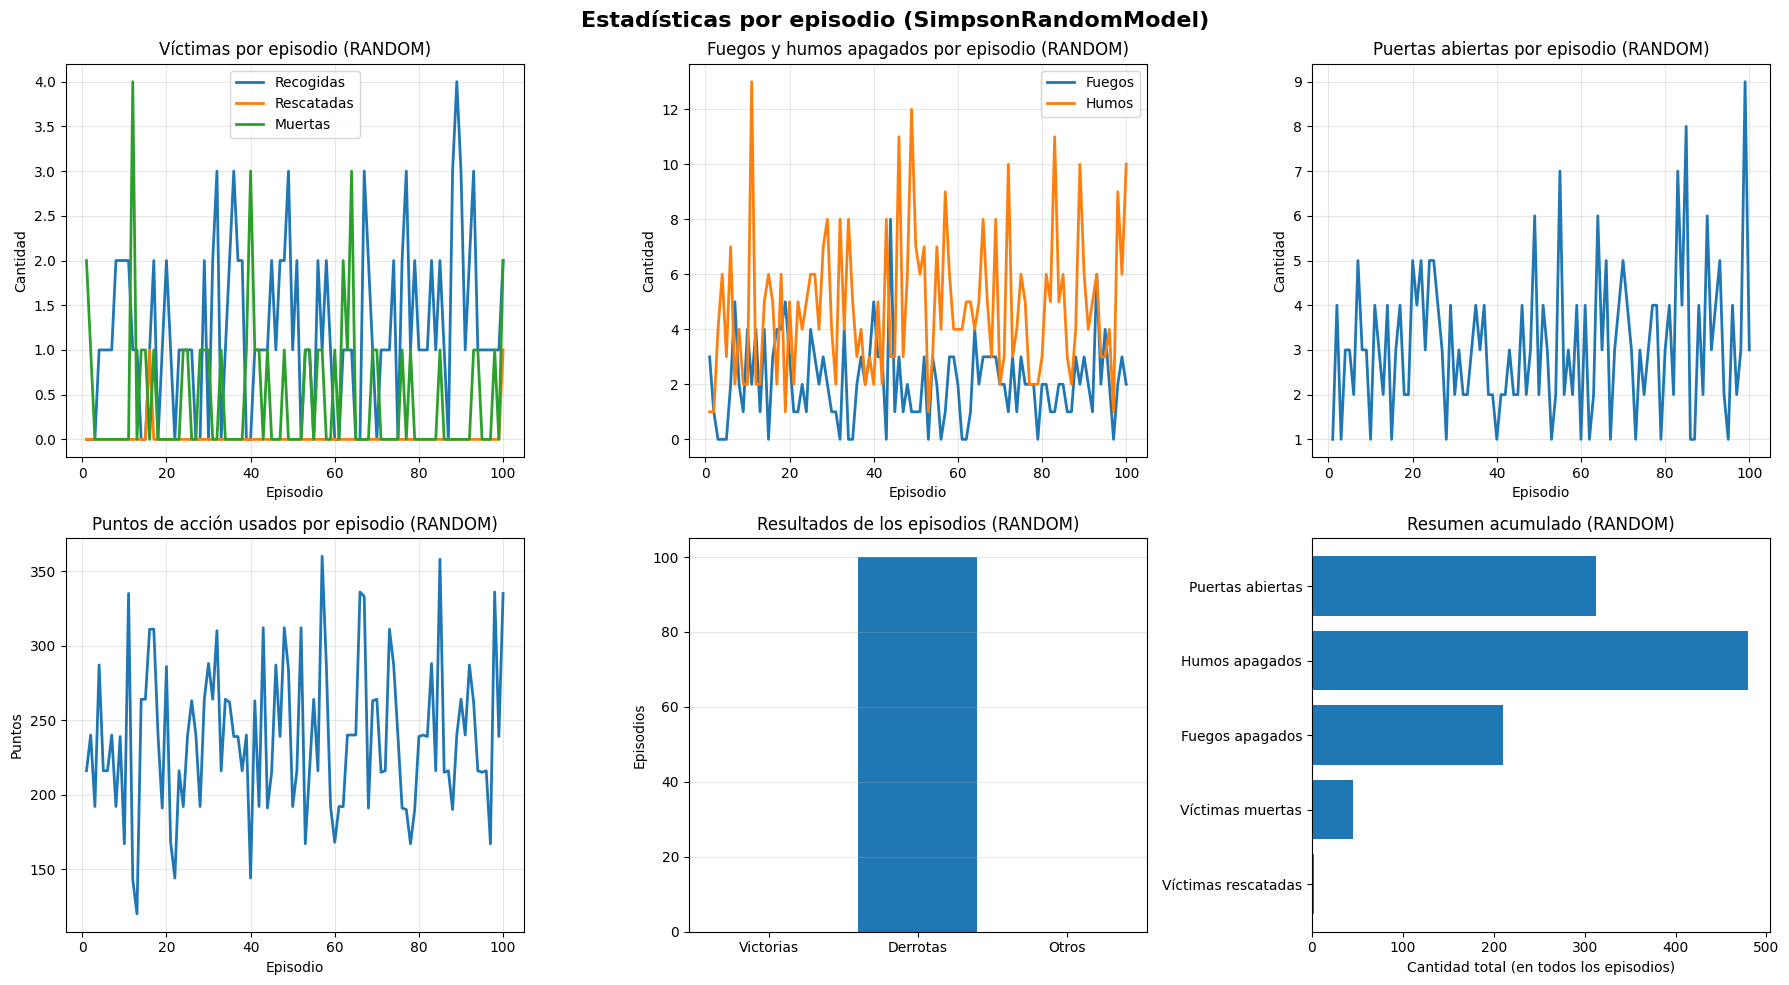

In [39]:
# Crear DataFrame a partir de la lista de episodios (RANDOM)
episodios_df = pd.DataFrame(episodios_stats)
display(episodios_df.head())

print("=" * 60)
print("RESUMEN GLOBAL DE LOS", N_EPISODIOS, "EPISODIOS (RANDOM)")
print("=" * 60)

wins = (episodios_df["game_result"] == "win").sum()
losses = (episodios_df["game_result"] == "lose").sum()
otros = N_EPISODIOS - wins - losses

print(f"Episodios jugados: {N_EPISODIOS}")
print(f"Victorias: {wins}")
print(f"Derrotas: {losses}")
print(f"Otros resultados: {otros}")
print()

# --------- MÉTRICAS QUE NOS INTERESAN ----------
metricas = [
    "total_victims_picked",
    "victims_rescued_total",
    "victims_dead_total",
    "total_fires_extinguished",
    "total_smokes_extinguished",
    "total_doors_opened",
    "total_action_points",
]

# --------- TOTALES GLOBALES (suma en todos los episodios) ----------
print("=" * 60)
print("TOTALES ACUMULADOS (TODOS LOS EPISODIOS) - RANDOM")
print("=" * 60)

for m in metricas:
    print(f"{m}: {episodios_df[m].sum()}")

print()

# --------- PROMEDIOS GLOBALES ----------
print("=" * 60)
print("PROMEDIOS POR EPISODIO (TODOS LOS EPISODIOS) - RANDOM")
print("=" * 60)

for m in metricas:
    print(f"{m} (promedio): {episodios_df[m].mean():.2f}")

print()

# --------- STATS SOLO DE PARTIDAS GANADAS ----------
wins_df = episodios_df[episodios_df["game_result"] == "win"]

print("=" * 60)
print("STATS SOLO DE EPISODIOS GANADOS - RANDOM")
print("=" * 60)

if len(wins_df) == 0:
    print("No hubo victorias :(")
else:
    print(f"Episodios ganados: {len(wins_df)}\n")

    print("TOTALES ACUMULADOS (SOLO WINS):")
    for m in metricas:
        print(f"{m}: {wins_df[m].sum()}")
    print()

    print("PROMEDIOS POR EPISODIO (SOLO WINS):")
    print(f"{m} (promedio): {wins_df[m].mean():.2f}")
    print()

# ==============================
# GRÁFICAS POR EPISODIO (RANDOM)
# ==============================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Estadísticas por episodio (SimpsonRandomModel)', fontsize=16, fontweight='bold')

# 1) Víctimas por episodio
axes[0, 0].plot(episodios_df["episodio"], episodios_df["total_victims_picked"], label='Recogidas', linewidth=2)
axes[0, 0].plot(episodios_df["episodio"], episodios_df["victims_rescued_total"], label='Rescatadas', linewidth=2)
axes[0, 0].plot(episodios_df["episodio"], episodios_df["victims_dead_total"], label='Muertas', linewidth=2)
axes[0, 0].set_xlabel('Episodio')
axes[0, 0].set_ylabel('Cantidad')
axes[0, 0].set_title('Víctimas por episodio (RANDOM)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2) Fuegos / humos por episodio
axes[0, 1].plot(episodios_df["episodio"], episodios_df["total_fires_extinguished"], label='Fuegos', linewidth=2)
axes[0, 1].plot(episodios_df["episodio"], episodios_df["total_smokes_extinguished"], label='Humos', linewidth=2)
axes[0, 1].set_xlabel('Episodio')
axes[0, 1].set_ylabel('Cantidad')
axes[0, 1].set_title('Fuegos y humos apagados por episodio (RANDOM)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3) Puertas abiertas por episodio
axes[0, 2].plot(episodios_df["episodio"], episodios_df["total_doors_opened"], linewidth=2)
axes[0, 2].set_xlabel('Episodio')
axes[0, 2].set_ylabel('Cantidad')
axes[0, 2].set_title('Puertas abiertas por episodio (RANDOM)')
axes[0, 2].grid(True, alpha=0.3)

# 4) Puntos de acción por episodio
axes[1, 0].plot(episodios_df["episodio"], episodios_df["total_action_points"], linewidth=2)
axes[1, 0].set_xlabel('Episodio')
axes[1, 0].set_ylabel('Puntos')
axes[1, 0].set_title('Puntos de acción usados por episodio (RANDOM)')
axes[1, 0].grid(True, alpha=0.3)

# 5) Resultados (win / lose / otros)
axes[1, 1].bar(['Victorias', 'Derrotas', 'Otros'], [wins, losses, otros])
axes[1, 1].set_ylabel('Episodios')
axes[1, 1].set_title('Resultados de los episodios (RANDOM)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6) Resumen total (suma en todos los episodios)
resumen_total = {
    'Víctimas rescatadas': episodios_df['victims_rescued_total'].sum(),
    'Víctimas muertas': episodios_df['victims_dead_total'].sum(),
    'Fuegos apagados': episodios_df['total_fires_extinguished'].sum(),
    'Humos apagados': episodios_df['total_smokes_extinguished'].sum(),
    'Puertas abiertas': episodios_df['total_doors_opened'].sum()
}
axes[1, 2].barh(list(resumen_total.keys()), list(resumen_total.values()))
axes[1, 2].set_xlabel('Cantidad total (en todos los episodios)')
axes[1, 2].set_title('Resumen acumulado (RANDOM)')

plt.tight_layout()
plt.show()

In [40]:
import mesa
print(mesa.__version__)


2.1.1


In [41]:
import json
import logging
from http.server import BaseHTTPRequestHandler, HTTPServer

# -----------------------------
# Config de tipos de piso
# -----------------------------

KITCHEN_CELLS = set([
    (3,4), (3,3), (3,2),
    (4,4), (4,3), (4,2), (4,1), (3,1),
    (5,4), (5,3), (5,2), (5,1),
])

GARAGE_CELLS = set([
    (6,8), (6,7), (6,6), (6,5),
    (7,8), (7,7), (7,6), (7,5),
    (8,8), (8,7), (8,6), (8,5),
])

SAFE_CELLS = set([
    (0, 0),
])

SPAWN_CELLS = set([
    (2,9), (3,9), (4,9),
    (0,0), (1,0), (2,0),
    (9,3), (9,4), (9,5),
])

# -----------------------------
# Config de episodios múltiples
# -----------------------------

N_EPISODES = 100       # cuántas partidas quieres correr
BASE_SEED = 0          # seed base, se irá incrementando

# Estado global
current_model = None
current_seed = BASE_SEED
episodes_played = 0
wins = 0
losses = 0
others = 0   # empates / cosas raras

# Stats por episodio y totales acumulados
episode_stats_list = []

total_stats = {
    "victims_rescued": 0,
    "victims_picked": 0,
    "fires_extinguished": 0,
    "smokes_extinguished": 0,
    "doors_opened": 0,
    "action_points": 0,
}

# ------------ helpers para exportar estado ------------

def build_tiles_and_edges(model):
    width, height = model.width, model.height

    tiles = []
    for x in range(width):
        for y in range(height):
            pos = (x, y)
            if pos in KITCHEN_CELLS:
                t = "kitchen"
            elif pos in GARAGE_CELLS:
                t = "garage"
            elif pos in SAFE_CELLS:
                t = "safe"
            elif pos in SPAWN_CELLS:
                t = "spawn"
            else:
                t = "inside" if pos in model.inside_cells else "outside"
            tiles.append({"x": x, "y": y, "type": t})

    edges = []
    for x in range(width):
        for y in range(height):
            from_pos = (x, y)
            for dx, dy in ((1, 0), (0, 1)):  # derecha y arriba
                nx, ny = x + dx, y + dy
                if not (0 <= nx < width and 0 <= ny < height):
                    continue
                to_pos = (nx, ny)
                edge_type = model.edges.get((from_pos, to_pos), "empty")
                if edge_type == "wall":
                    e_type = "wall"
                elif edge_type == "door_closed":
                    e_type = "door_closed"
                elif edge_type == "door_open":
                    e_type = "door_open"
                else:
                    continue
                edges.append({
                    "ax": x, "ay": y,
                    "bx": nx, "by": ny,
                    "type": e_type,
                })

    return tiles, edges


def build_hazards(model):
    hazards = []
    for x in range(model.width):
        for y in range(model.height):
            h = model.hazard_grid[x, y]
            if h == model.FIRE:
                hazards.append({"x": x, "y": y, "kind": "fire"})
            elif h == model.SMOKE:
                hazards.append({"x": x, "y": y, "kind": "smoke"})
    return hazards


def build_agents(model):
    agents = []
    for ag in model.schedule.agents:
        x, y = ag.pos
        agents.append({
            "id": int(ag.unique_id),
            "x": int(x),
            "y": int(y),
            # estos campos los dejo por compatibilidad con la API estratégica
            "role": getattr(ag, "role", None),
            "carrying_victim": bool(getattr(ag, "carrying_victim", False)),
        })
    return agents


def build_victims(model):
    victims = []
    for x in range(model.width):
        for y in range(model.height):
            if model.victim_grid[x, y]:
                victims.append({"x": x, "y": y})
    return victims


def build_full_state(model, include_tiles_edges=False):
    """
    Estado que mandamos a Unity en /floor y /step.
    """
    tiles, edges = ([], [])
    if include_tiles_edges:
        tiles, edges = build_tiles_and_edges(model)

    payload = {
        "width": model.width,
        "height": model.height,
        "tiles": tiles,
        "edges": edges,
        "hazards": build_hazards(model),
        "agents": build_agents(model),
        "victims": build_victims(model),
        "game_over": bool(model.game_over),
        "result": model.game_result,
    }
    return payload


def new_model(seed):
    """
    Crea un SimpsonRandomModel nuevo.
    Ajusta num_victims si quieres que coincida exactamente con el estratégico.
    """
    return SimpsonRandomModel(
        width=10,
        height=10,
        num_firefighters=6,
        num_victims=4,   # si quieres 9 como antes, cambia este valor
        seed=seed,
    )


def compute_episode_stats(model):
    """
    Suma los contadores de TODOS los agentes del modelo.
    Ajusta los nombres si tus agentes usan otros.
    """
    stats = {
        "victims_rescued": 0,
        "victims_picked": 0,
        "fires_extinguished": 0,
        "smokes_extinguished": 0,
        "doors_opened": 0,
        "action_points": 0,
    }

    for ag in model.schedule.agents:
        stats["victims_rescued"]     += getattr(ag, "victims_rescued", 0)
        stats["victims_picked"]      += getattr(ag, "victims_picked", 0)
        stats["fires_extinguished"]  += getattr(ag, "fires_extinguished", 0)
        stats["smokes_extinguished"] += getattr(ag, "smokes_extinguished", 0)
        stats["doors_opened"]        += getattr(ag, "doors_opened", 0)
        stats["action_points"]       += getattr(ag, "action_points", 0)

    return stats

# ------------ handlers HTTP ------------

class FloorHandler(BaseHTTPRequestHandler):
    def do_POST(self):
        global current_model, current_seed
        global episodes_played, wins, losses, others
        global episode_stats_list, total_stats

        length = int(self.headers.get("Content-Length", 0))
        raw = self.rfile.read(length) if length > 0 else b"{}"
        try:
            data = json.loads(raw.decode("utf-8"))
        except Exception:
            data = {}

        # ----- /floor: crear modelo nuevo (reinicia la corrida de episodios) -----
        if self.path == "/floor":
            # Si mandas una seed desde Unity, úsala como base
            base_from_body = data.get("seed", None)
            if base_from_body is not None:
                BASE = int(base_from_body)
            else:
                BASE = BASE_SEED

            # reset de seeds, episodios y resultados
            current_seed = BASE
            episodes_played = 0
            wins = 0
            losses = 0
            others = 0

            # reset de stats
            episode_stats_list.clear()
            for k in total_stats:
                total_stats[k] = 0

            current_model = new_model(current_seed)

            layout = build_full_state(current_model, include_tiles_edges=True)
            # info extra de stats (Unity la ignora si no tiene campos)
            layout["episode"] = 1
            layout["wins"] = wins
            layout["losses"] = losses
            layout["others"] = others
            layout["current_seed"] = current_seed
            layout["max_episodes"] = N_EPISODES
            layout["simulation_done"] = False

            # totales en 0 al inicio
            layout["total_stats"] = total_stats
            layout["episode_finished"] = False
            layout["episode_stats"] = None

            resp_bytes = json.dumps(layout).encode("utf-8")
            self.send_response(200)
            self.send_header("Content-Type", "application/json")
            self.send_header("Content-Length", str(len(resp_bytes)))
            self.end_headers()
            self.wfile.write(resp_bytes)
            return

        # ----- /step: avanzar 1 turno del modelo random -----
        elif self.path == "/step":
            if current_model is None:
                self.send_response(400)
                self.end_headers()
                self.wfile.write(b'{"error": "No model. Call /floor first."}')
                return

            # Si ya jugamos todos los episodios, no avanzamos más
            if episodes_played >= N_EPISODES:
                state = build_full_state(current_model, include_tiles_edges=True)
                state["simulation_done"] = True
                state["episode"] = episodes_played
                state["wins"] = wins
                state["losses"] = losses
                state["others"] = others
                state["current_seed"] = current_seed
                state["max_episodes"] = N_EPISODES
                state["episode_finished"] = False
                state["episode_stats"] = None
                state["total_stats"] = total_stats

                resp_bytes = json.dumps(state).encode("utf-8")
                self.send_response(200)
                self.send_header("Content-Type", "application/json")
                self.send_header("Content-Length", str(len(resp_bytes)))
                self.end_headers()
                self.wfile.write(resp_bytes)
                return

            # Avanzar 1 paso
            current_model.step()

            # Construimos el estado de ESTE episodio (tablero actual)
            state = build_full_state(current_model, include_tiles_edges=True)

            # Por defecto, asumimos que el episodio sigue
            state["episode_finished"] = False
            state["episode_stats"] = None
            state["simulation_done"] = False

            # Si se terminó la partida, actualizamos stats y creamos siguiente modelo
            if current_model.game_over:
                result = getattr(current_model, "game_result", "")
                r_low = result.lower() if isinstance(result, str) else ""

                if ("win" in r_low) or ("victory" in r_low) or ("gan" in r_low):
                    wins += 1
                elif ("lose" in r_low) or ("derrota" in r_low) or ("perd" in r_low):
                    losses += 1
                else:
                    others += 1

                # --- stats de este episodio ---
                ep_stats = compute_episode_stats(current_model)
                episode_stats_list.append(ep_stats)
                for k, v in ep_stats.items():
                    total_stats[k] += v

                logging.info(f"Episode {episodes_played + 1} finished. Stats: {ep_stats}")
                logging.info(f"Total stats so far: {total_stats}")

                episodes_played += 1
                state["episode_finished"] = True
                state["episode_stats"] = ep_stats

                # Si todavía faltan episodios, preparamos el siguiente modelo
                if episodes_played < N_EPISODES:
                    current_seed += 1
                    current_model = new_model(current_seed)
                else:
                    # ya no creamos más modelos; marcamos simulación terminada
                    state["simulation_done"] = True

            # episode index que se reporta:
            if current_model.game_over:
                # acabamos de terminar un episodio; el número es episodes_played
                episode_index = episodes_played
            else:
                # estamos dentro del episodio siguiente (episodes_played ya jugados)
                episode_index = episodes_played + 1

            # Añadimos stats al JSON (Unity los ignora si StepResponse no los tiene)
            state["episode"] = episode_index
            state["wins"] = wins
            state["losses"] = losses
            state["others"] = others
            state["current_seed"] = current_seed
            state["max_episodes"] = N_EPISODES

            # totales acumulados de las partidas jugadas hasta ahora
            state["total_stats"] = total_stats

            resp_bytes = json.dumps(state).encode("utf-8")
            self.send_response(200)
            self.send_header("Content-Type", "application/json")
            self.send_header("Content-Length", str(len(resp_bytes)))
            self.end_headers()
            self.wfile.write(resp_bytes)
            return

        # cualquier otra ruta
        self.send_response(404)
        self.end_headers()
        self.wfile.write(b"Not found")


def run(port=8585):
    logging.basicConfig(level=logging.INFO)
    server_address = ("", port)
    httpd = HTTPServer(server_address, FloorHandler)
    logging.info(f"Starting http server on port {port}...\n")
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:
        pass
    httpd.server_close()
    logging.info("Stopping http server...\n")


# Lanza el servidor
run(8585)

INFO:root:Starting http server on port 8585...

127.0.0.1 - - [04/Dec/2025 02:12:30] "POST /floor HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 02:12:44] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 02:12:45] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 02:12:45] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 02:12:46] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 02:12:46] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 02:12:47] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 02:12:47] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 02:12:48] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 02:12:49] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 02:12:50] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 02:12:51] "POST /step HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2025 02:12:51] "POST /step HTTP/1.1" 200 -
INFO:root:Episode 1 finished. Stats: {'victims_rescued': 0, 'victims_picked': 2, 'fires_extinguished': 2, 

Game Over: el edificio colapsó por demasiadas paredes rotas.


127.0.0.1 - - [04/Dec/2025 02:12:52] "POST /step HTTP/1.1" 200 -
INFO:root:Stopping http server...

